[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/abdn-cs3033-ai/practicals/blob/main/week08/tutorial7-mdp.ipynb)

# CS3033: Artificial Intelligence

## Tutorial 07: Markov Decision Processes

#### Prof. Felipe Meneguzzi

Adapted from code in the [AIMA-Python](https://github.com/aimacode/aima-python) public repository.

In order to run this tutorial, you need to download the auxiliary files from Github into your notebook, which we do with Jupyter's shell commands (if you downloaded the entire repo, the code below is not necessary).

In [1]:
try:
  import google.colab
  print("We are in Google colab, we need to clone the repo")
  !pip3 install seaborn --user
  !git clone https://github.com/abdn-cs3033-ai/practicals.git
  %cd practicals/week08
except:
  print("Not in colab")

We are in Google colab, we need to clone the repo
Cloning into 'practicals'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 305 (delta 21), reused 20 (delta 15), pack-reused 269
Receiving objects: 100% (305/305), 4.11 MiB | 7.81 MiB/s, done.
Resolving deltas: 100% (150/150), done.
/content/practicals/week08


## Markov Decision Processes

**Markov Decision Processes** are stochastic processes in which an agent partially controls transitions between states by choosing actions, and which the subsequent transition probabilities between states follow the Markovian property. This means that single states include all the information relevant to compute the transition probability to other states.

Recall the elements of an MDP:

- A finite set of states $\mathcal{S}$
- A finite set of actions $\mathcal{A}$
- A *markovian* transition model $T(s,a,s') = \mathbb{P}(S_{t+1}=s' \mid S_t = s, A_t = a)$
- A reward function $R(s)$, alternatively $R(s,a) = \mathbb{E}[ R_{t+1} \mid S_t = s, A_t = a]$
- A discount factor $\gamma$

We will implement MDPs in the **`MDP`** class below.

In [2]:
import random
from collections import defaultdict

import numpy as np

from utils4e import vector_add, orientations, turn_right, turn_left

from notebook import psource, pseudocode


class MDP:
    """A Markov Decision Process, defined by an initial state, transition model,
    and reward function. We also keep track of a gamma value, for use by
    algorithms. The transition model is represented somewhat differently from
    the text. Instead of P(s' | s, a) being a probability number for each
    state/state/action triplet, we instead have T(s, a) return a
    list of (p, s') pairs. We also keep track of the possible states,
    terminal states, and actions for each state. [Page 646]"""

    def __init__(self, init, actlist, terminals, transitions=None, reward=None, states=None, gamma=0.9):
        if not (0 < gamma <= 1):
            raise ValueError("An MDP must have 0 < gamma <= 1")

        # collect states from transitions table if not passed.
        self.states = states or self.get_states_from_transitions(transitions)

        self.init = init

        if isinstance(actlist, list):
            # if actlist is a list, all states have the same actions
            self.actlist = actlist

        elif isinstance(actlist, dict):
            # if actlist is a dict, different actions for each state
            self.actlist = actlist

        self.terminals = terminals
        self.transitions = transitions or {}
        if not self.transitions:
            print("Warning: Transition table is empty.")

        self.gamma = gamma

        self.reward = reward or {s: 0 for s in self.states}

        # self.check_consistency()

    def R(self, state):
        """Return a numeric reward for this state."""
        if state not in self.reward: return None
        return self.reward[state]

    def T(self, state, action):
        """Transition model. From a state and an action, return a list
        of (probability, result-state) pairs."""

        if not self.transitions:
            raise ValueError("Transition model is missing")
        else:
            return self.transitions[state][action]

    def actions(self, state):
        """Return a list of actions that can be performed in this state. By default, a
        fixed list of actions, except for terminal states. Override this
        method if you need to specialize by state."""

        if state in self.terminals:
            return [None]
        else:
            return self.actlist

    def get_states_from_transitions(self, transitions):
        if isinstance(transitions, dict):
            s1 = set(transitions.keys())
            s2 = set(tr[1] for actions in transitions.values()
                     for effects in actions.values()
                     for tr in effects)
            return s1.union(s2)
        else:
            print('Could not retrieve states from transitions')
            return None

    def check_consistency(self):

        # check that all states in transitions are valid
        assert set(self.states) == self.get_states_from_transitions(self.transitions)

        # check that init is a valid state
        assert self.init in self.states

        # check reward for each state
        assert set(self.reward.keys()) == set(self.states)

        # check that all terminals are valid states
        assert all(t in self.states for t in self.terminals)

        # check that probability distributions for all actions sum to 1
        for s1, actions in self.transitions.items():
            for a in actions.keys():
                s = 0
                for o in actions[a]:
                    s += o[0]
                assert abs(s - 1) < 0.001

The class above has attributes for the transition model, the reward function and other elements of an MDP.

The **`__init__`** method takes in the following parameters:

- `init`: the initial state.
- `actlist`: List of actions possible in each state.
- `terminals`: List of terminal states where only possible action is exit
- `gamma`: Discounting factor $\gamma$. This makes sure that delayed rewards have less value compared to immediate ones.

The **`R`** method returns the reward for each state by using the `self.reward` `dict`. This corresponds to the $R(s)$ formulation.

The **`T`** method is somewhat different from the text. Here we return (probability, $s'$) pairs where $s'$ belongs to list of possible state by taking action $a$ in state $s$.

The **`actions`** method returns list of actions possible in each state. By default, it returns all actions for states other than terminal states.

Note that we also import a number of auxiliary functions you will need in implementing the algorithms we require, specifically:

- ```vector_add```
- ```orientations```
- ```turn_right```
- ```turn_left```

For this tutorial, we will use a specific subclass of the `MDP` we just created that we specialise to represent the grid worlds we saw in the lecture.

In [3]:
from IPython.display import HTML, display

class GridMDP(MDP):
    """A two-dimensional grid MDP, as in [Figure 16.1]. All you have to do is
    specify the grid as a list of lists of rewards; use None for an obstacle
    (unreachable state). Also, you should specify the terminal states.
    An action is an (x, y) unit vector; e.g. (1, 0) means move east."""

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse()  # because we want row 0 on bottom, not on top
        reward = {}
        states = set()
        self.rows = len(grid)
        self.cols = len(grid[0])
        self.grid = grid
        for x in range(self.cols):
            for y in range(self.rows):
                if grid[y][x]:
                    states.add((x, y))
                    reward[(x, y)] = grid[y][x]
        self.states = states
        actlist = orientations
        transitions = {}
        for s in states:
            transitions[s] = {}
            for a in actlist:
                transitions[s][a] = self.calculate_T(s, a)
        MDP.__init__(self, init, actlist=actlist,
                     terminals=terminals, transitions=transitions,
                     reward=reward, states=states, gamma=gamma)

    def calculate_T(self, state, action):
        if action:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]
        else:
            return [(0.0, state)]

    def T(self, state, action):
        return self.transitions[state][action] if action else [(0.0, state)]

    def go(self, state, direction):
        """Return the state that results from going in this direction."""

        state1 = tuple(vector_add(state, direction))
        return state1 if state1 in self.states else state

    def to_grid(self, mapping, default = None):
        """Convert a mapping from (x, y) to v into a [[..., v, ...]] grid."""

        return list(reversed([[mapping.get((x, y), default)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0): '>', (0, 1): '^', (-1, 0): '<', (0, -1): 'v', None: '.'}
        return self.to_grid({s: chars[a] for (s, a) in policy.items()})

    def display_policy(self, policy):
        """Pretty prints the policy in HTML for a Jupyter Notebook"""
        # SYMBOLS = ['&rarr;', '&uarr;', '&larr;', '&darr;']
        SYMBOLS = {(1, 0): '&rarr;', (0, 1): '&uarr;', (-1, 0): '&larr;', (0, -1): '&darr;', None: '&#x25CE;'}

        p_policy = self.to_grid({s: SYMBOLS[a] for (s, a) in policy.items()}, '&#x25FE;')

        display(HTML(
        '<table style="font-size:300%;border: thick solid;"><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in p_policy))))

Note that we have defined the class for grids, we can represent examples such as the one we saw in the lecture, reproduced below.

![Grid World](img/mdp-bare.svg "Grid World MDP illustration")

We instantiate the object **`mdp`** of the class using a list of lists for both the transition and the sensor model. The code below instantiates the Grid World shown above.

In [4]:
mdp = GridMDP([[-3, -3, -3, +100],
            [-3, None,  -3, -100],
            [-3, -3, -3, -3]],
            terminals=[(3, 2), (3, 1)])


The **__init__** method takes **grid** as an extra parameter compared to the MDP class. The grid is a nested list of rewards in states.

The **`go`** method returns the state by going in particular direction by using `vector_add`.

The **`actions`** method returns list of actions possible in each state. By default, it returns all actions for states other than terminal states.

**`to_arrows`** are used for representing the policy in a grid-like text format. By contrast `display_policy` pretty prints the policy in HTML within the notebook.

The **`T`** method is somewhat different from the text. Here we return (probability, $s'$) pairs where $s'$ belongs to list of possible state by taking action $a$ in state $s$. Thus **`T(state, action)`** yields the transition model of the MDP for a given state and action. Note that the indexes in our MDP start in zero.

Similarly, the **`R(state)`** method returns the immediate reward for a state.

In [5]:
from utils4e import NORTH
print(mdp.T((2,2), NORTH))
print(mdp.R((3,2)))
print(mdp.R((1,1)))
print(mdp.states)

[(0.8, (2, 2)), (0.1, (3, 2)), (0.1, (1, 2))]
100
None
{(0, 1), (1, 2), (2, 1), (0, 0), (3, 1), (2, 0), (3, 0), (0, 2), (2, 2), (1, 0), (3, 2)}


## Solving MDPs

Now that we have looked how to represent MDPs. We will implement algorithms to solve them. Our ultimate goal is to obtain an optimal policy. We start with the Value Iteration algorithm and a visualisation that should help us understand it better.

We start by calculating Value/Utility for each of the states. The Value of each state is the expected sum of discounted future rewards given we start in that state and follow a particular policy $\pi$. The value or the utility of a state is given by:

$$U(s)=R(s)+\gamma\max_{a\epsilon A(s)}\sum_{s'} P(s'\ |\ s,a)U(s')$$

This is called the Bellman equation. The Value Iteration algorithm (**Fig. 17.4** in the book) relies on finding solutions of this Equation. The intuition Value Iteration works is because values propagate through the state space by means of local updates. This point will we more clear after we encounter the visualisation. For more information you can refer to **Section 17.2** of the book.

Let us first review the pseudocode for value iteration

In [6]:
pseudocode("Value-Iteration")

### AIMA3e
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; _R_(_s_) &plus; _&gamma;_ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma; _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).

---

## AIMA4e  
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_,_a_,_s&prime;_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; max<sub>_a_ &isin; _A_(_s_)</sub> Q-VALUE(_mdp_,_s_,_a_,_U_)  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).
~

### Value Iteration
Using the pseudocode above we will implement the value iteration algorithm.

Our implementation takes as inputs two parameters, an MDP to solve and epsilon, the maximum error allowed in the utility of any state. It returns a dictionary containing utilities where the keys are the states and values represent utilities.

Value Iteration starts with arbitrary initial values for the utilities, calculates the right-hand side of the Bellman equation and plugs it into the left-hand side, thereby updating the utility of each state from the utilities of its neighbours.
This is repeated until the utility vector we update reaches an equilibrium.
It works on the principle of _Dynamic Programming_ - using precomputed information to simplify the subsequent computation.
If $U_i(s)$ is the utility value for state $s$ at the $i$ th iteration, the iteration step, called Bellman update, looks like this:

$$ U_{i+1}(s) \leftarrow R(s) + \gamma \max_{a \epsilon A(s)} \sum_{s'} P(s'\ |\ s,a)U_{i}(s') $$

As you might have noticed, `value_iteration` has an infinite loop. How do we decide when to stop iterating?
The concept of _contraction_ successfully explains the convergence of value iteration.
Refer to **Section 17.2.3** of the book for a detailed explanation.
In the algorithm, we calculate a value $delta$ that measures the difference in the utilities of the current time step and the previous time step.

$$\delta = \max{(\delta, \begin{vmatrix}U_{i + 1}(s) - U_i(s)\end{vmatrix})}$$

This value of delta decreases as the values of $U_i$ converge.
We terminate the algorithm if the $\delta$ value is less than a threshold value determined by the hyperparameter _epsilon_.

$$\delta \lt \epsilon \frac{(1 - \gamma)}{\gamma}$$

To summarize, the Bellman update is a _contraction_ by a factor of $gamma$ on the space of utility vectors.
Hence, from the properties of contractions in general, it follows that `value_iteration` always converges to a unique solution of the Bellman equations whenever $gamma$ is less than 1.
We then terminate the algorithm when we reach a reasonable approximation.
In practice, it often occurs that the policy $pi$ becomes optimal long before the utility function converges. For the given 4 x 3 environment with $gamma = 0.9$, the policy $pi$ is optimal when $i = 4$ (at the 4th iteration), even though the maximum error in the utility function is stil 0.46. This can be clarified from **figure 17.6** in the book. Hence, to increase computational efficiency, we often use another method to solve MDPs called Policy Iteration which we will see in the later part of this notebook.

In this tutorial, you only need to implement the Bellman update within the algorithm.



In [9]:
# ______________________________________________________________________________
# 16.1.3 The Bellman equation for utilities

### You can use this function in your value iteration implementation (but you don't need it)
def q_value(mdp, s, a, U):
    """Returns the expected value of taking an action `a` at a state `s` under utility `U`"""
    if not a:
        return mdp.R(s)
    res = 0
    for p, s_prime in mdp.T(s, a):
        res += p * (mdp.R(s) + mdp.gamma * U[s_prime])
    return res

def value_iteration(mdp, epsilon=0.001):
    """Solving an MDP by value iteration. [Figure 16.6]"""

    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            ### Your code here
            U1[s] = max(q_value(mdp, s, a, U) for a in mdp.actions(s))
            delta = max(delta, abs(U1[s] - U[s]))
            ### End code
            delta = max(delta, abs(U1[s] - U[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return U

You will notice that the `value_iteration` function above does not return a policy, just the discounted returns for each state stored in the `U` data structure.

In order to extract a policy out of these values, we need a function that selects the action with the best expected reward for each state, essentially implementing the policy extraction we saw in the lecture:

$$\pi(s) = \argmax_{a} \sum_{s'}P(s' \mid s,a)*V(s')$$

This is what you will implement below.

In [10]:
def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action."""

    pi = {}
    for s in mdp.states:
        ### Your code here
        pi[s] = max(mdp.actions(s), key=lambda a: q_value(mdp, s, a, U))
        ### End code
    return pi

For now, let us solve the GridMDP we defined, using `value_iteration`.

In [11]:
mdp = GridMDP([[-3, -3, -3, +100],
            [-3, None,  -3, -100],
            [-3, -3, -3, -3]],
            terminals=[(3, 2), (3, 1)], gamma=1)
U = value_iteration(mdp, epsilon=0.01)
policy = best_policy(mdp,U)
print(policy)

{(0, 1): (0, 1), (1, 2): (1, 0), (2, 1): (0, 1), (0, 0): (0, 1), (3, 1): None, (2, 0): (-1, 0), (3, 0): (-1, 0), (0, 2): (1, 0), (2, 2): (1, 0), (1, 0): (-1, 0), (3, 2): None}


Let's look at the resulting policy

In [14]:
mdp.display_policy(policy)

→,→,→,◎
↑,◾,↑,◎
↑,←,←,←


### Visualizing Value Iteration

To illustrate that values propagate out of states let us create a simple visualisation. We will be using a modified version of the ```value_iteration``` function which will store U over time. We will also remove the parameter epsilon and instead add the number of iterations we want.

In [15]:
def value_iteration_instru(mdp, iterations=20):
    U_over_time = []
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for _ in range(iterations):
        U = U1.copy()
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
        U_over_time.append(U)
    return U_over_time

Next, we define a function to create the visualisation from the utilities returned by **value_iteration_instru**. Do not worry with the code that immediately follows as it is the usage of Matplotib with IPython Widgets. If you are interested in reading more about these visit [ipywidgets.readthedocs.io](http://ipywidgets.readthedocs.io)

In [16]:
columns = 4
rows = 3
U_over_time = value_iteration_instru(mdp)

In [17]:
%matplotlib inline
from notebook import make_plot_grid_step_function

plot_grid_step = make_plot_grid_step_function(columns, rows, U_over_time)

In [18]:
import ipywidgets as widgets
from IPython.display import display
from notebook import make_visualize

iteration_slider = widgets.IntSlider(min=1, max=15, step=1, value=0)
w=widgets.interactive(plot_grid_step,iteration=iteration_slider)
display(w)

visualize = True
visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:',options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])
a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step=time_select)
display(a)

interactive(children=(IntSlider(value=1, description='iteration', max=15, min=1), Output()), _dom_classes=('wi…

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Del…

Move the slider above to observe how the utility changes across iterations. It is also possible to move the slider using arrow keys or to jump to the value by directly editing the number with a double click. The **Visualize Button** will automatically animate the slider for you. The **Extra Delay Box** allows you to set time delay in seconds up to one second for each time step.

### Effects of the discount factor

Here we plot the difference between each iteration of the Value Iteration algorithm using different discount factors. The closest the $\gamma$ is to zero, the more the values contract over time.

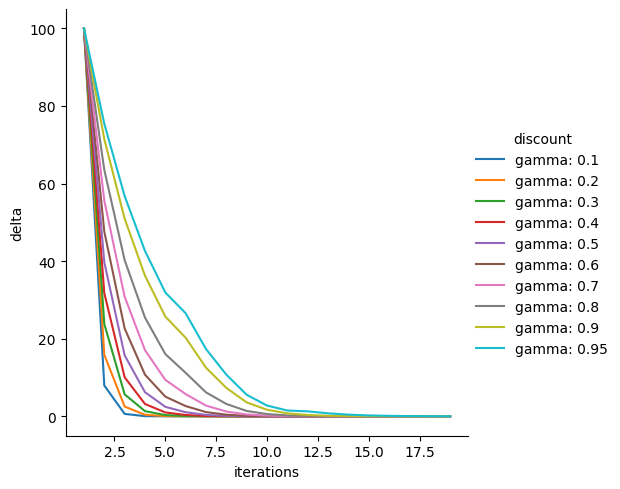

In [19]:
def plot_delta(mdp, discounts=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95], epsilon=0.001, max_iter=1000):
    data_list = []
    import pandas as pd
    from matplotlib import pyplot as plt
    %matplotlib inline
    import seaborn as sns
    data_list = []
    for d in discounts:
        mdp.gamma = d
        U_over_time = value_iteration_instru(mdp)
        for i in range(len(U_over_time)):
            if i > 0:
                v = np.array(list(U_over_time[i-1].values()))
                vprime = np.array(list(U_over_time[i].values()))
                value = max(abs(vprime - v))
                data_list.append([value, 'gamma: ' + str(d), i])
    data_frame2 = pd.DataFrame(data_list, columns=['delta', 'discount', 'iterations'])
    ax = sns.relplot(x = 'iterations', y = 'delta', hue='discount', kind="line", data=data_frame2)
mdp = GridMDP([[-3, -3, -3, +100],
            [-3, None,  -3, -100],
            [-3, -3, -3, -3]],
            terminals=[(3, 2), (3, 1)])
plot_delta(mdp)



### Policy Iteration

We have already seen that value iteration converges to the optimal policy long before it accurately estimates the utility function.
If one action is clearly better than all the others, then the exact magnitude of the utilities in the states involved need not be precise.
The policy iteration algorithm works on this insight.
The algorithm executes two fundamental steps:

- **Policy evaluation**: Given a policy _&#960;&#7522;_, calculate _U&#7522; = U(&#960;&#7522;)_, the utility of each state if _&#960;&#7522;_ were to be executed.
- **Policy improvement**: Calculate a new policy _&#960;&#7522;&#8330;&#8321;_ using one-step look-ahead based on the utility values calculated.

The algorithm terminates when the policy improvement step yields no change in the utilities.
Refer to **Figure 17.6** in the book to see how this is an improvement over value iteration.
We now have a simplified version of the Bellman equation:

$$U_i(s) = R(s) + \gamma \sum_{s'}P(s'\ |\ s, \pi_i(s))U_i(s')$$

An important observation in this equation is that this equation does not have the `max` operator, which makes it linear.
For _n_ states, we have _n_ linear equations with _n_ unknowns, which can be solved exactly in time _**O(n&#179;)**_.
For more implementational details, have a look at **Section 17.3**.

Let us now look at how we can compute the expected utility and how we can implement `policy_iteration`.

In [21]:
def expected_utility(a, s, U, mdp):
    """The expected utility of doing a in state s, according to the MDP and U."""
    ### Your code here
    return sum(p * U[s_prime] for (p, s_prime) in mdp.T(s,a))
    ### End code

And we can test the algorithm with the example in the book for the square to the left of the positive reward terminal state.

In [24]:
mdp = GridMDP([[-3, -3, -3, +100],
        [-3, None,  -3, -100],
        [-3, -3, -3, -3]],
        terminals=[(3, 2), (3, 1)])

U = value_iteration(mdp)

EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]

## Check that we computed this correctly
assert(abs(expected_utility(EAST, (2,2), U, mdp) - 93.2) < 0.05)

We do not need to do _exact_ policy evaluation.
We can instead approximate them reasonably by performing some number of simplified value iteration steps.
The simplified Bellman update equation for the process is:

$$U_{i+1}(s) \leftarrow R(s) + \gamma\sum_{s'}P(s'\ |\ s,\pi_i(s))U_{i}(s')$$

which we repeat _k_ times to produce the next utility estimate. This is called _modified policy iteration_.

In [23]:
pseudocode('Value-Iteration')

### AIMA3e
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; _R_(_s_) &plus; _&gamma;_ max<sub>_a_ &isin; _A_(_s_)</sub> &Sigma; _P_(_s&prime;_ &vert; _s_, _a_) _U_\[_s&prime;_\]  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).

---

## AIMA4e  
__function__ VALUE-ITERATION(_mdp_, _&epsi;_) __returns__ a utility function  
&emsp;__inputs__: _mdp_, an MDP with states _S_, actions _A_(_s_), transition model _P_(_s&prime;_ &vert; _s_, _a_),  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;rewards _R_(_s_,_a_,_s&prime;_), discount _&gamma;_  
&emsp;&emsp;&emsp;_&epsi;_, the maximum error allowed in the utility of any state  
&emsp;__local variables__: _U_, _U&prime;_, vectors of utilities for states in _S_, initially zero  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_&delta;_, the maximum change in the utility of any state in an iteration  

&emsp;__repeat__  
&emsp;&emsp;&emsp;_U_ &larr; _U&prime;_; _&delta;_ &larr; 0  
&emsp;&emsp;&emsp;__for each__ state _s_ in _S_ __do__  
&emsp;&emsp;&emsp;&emsp;&emsp;_U&prime;_\[_s_\] &larr; max<sub>_a_ &isin; _A_(_s_)</sub> Q-VALUE(_mdp_,_s_,_a_,_U_)  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert; &gt; _&delta;_ __then__ _&delta;_ &larr; &vert; _U&prime;_\[_s_\] &minus; _U_\[_s_\]  &vert;  
&emsp;__until__ _&delta;_ &lt; _&epsi;_(1 &minus; _&gamma;_)&sol;_&gamma;_  
&emsp;__return__ _U_  

---
__Figure ??__ The value iteration algorithm for calculating utilities of states. The termination condition is from Equation (__??__).
~

In [25]:
def policy_iteration(mdp):
    """Solve an MDP by policy iteration [Figure 17.7]"""

    U = {s: 0 for s in mdp.states}
    pi = {s: random.choice(mdp.actions(s)) for s in mdp.states}
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a_star = max(mdp.actions(s), key=lambda a: q_value(mdp, s, a, U))
            # a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
            if q_value(mdp, s, a_star, U) > q_value(mdp, s, pi[s], U):
                pi[s] = a_star
                unchanged = False
        if unchanged:
            return pi


def policy_evaluation(pi, U, mdp, k=20):
    """Return an updated utility mapping U from each state in the MDP to its
    utility, using an approximation (modified policy iteration)."""

    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum(p * U[s1] for (p, s1) in T(s, pi[s]))
    return U

We can now test this new algorithm with our Grid World.

In [26]:
mdp = GridMDP([[-3, -3, -3, +100],
        [-3, None,  -3, -100],
        [-3, -3, -3, -3]],
        terminals=[(3, 2), (3, 1)], gamma=1)

pi = policy_iteration(mdp)
print("This is the policy from Policy Iteration")
mdp.display_policy(pi)
# As well as compare the result of computing policies using value iteration for comparison

Uvi = value_iteration(mdp)
piVi = best_policy(mdp, Uvi)
print("This is the policy from Value Iteration")
mdp.display_policy(piVi)

This is the policy from Policy Iteration


→,→,→,◎
↑,◾,↑,◎
↑,←,←,←


This is the policy from Value Iteration


→,→,→,◎
↑,◾,↑,◎
↑,←,←,←


We can try to reproduce all the cases we saw in the lecture for different immediate rewards in the code below, see how they look like.

![Sequential Decision Policies](img/sequential-decision-policies.svg "Sequential Decision Policies")

#### Case 1

Notice that, because the cost of taking a step is fairly small compared with the penalty for ending up in `(4, 2)` by accident, the optimal policy is conservative.
In state `(3, 1)` it recommends taking the long way round, rather than taking the shorter way and risking getting a large negative reward of -1 in `(4, 2)`.

In [27]:
# Note that this environment is also initialized in mdp.py by default
ntr = -0.04 # setting the non-terminal reward
mdp = GridMDP([[ntr, ntr, ntr, +1],
                [ntr, None, ntr, -1],
                [ntr, ntr, ntr, ntr]],
                terminals=[(3, 2), (3, 1)], gamma=1)

pi = best_policy(mdp, value_iteration(mdp, .001))

mdp.display_policy(pi)

→,→,→,◎
↑,◾,↑,◎
↑,←,←,←


#### Case 2
$R(s) = -0.4$ in all states except in terminal states

In [31]:
ntr = -0.4 # setting the non-terminal reward
mdp = GridMDP([[ntr, ntr, ntr, +1],
                [ntr, None, ntr, -1],
                [ntr, ntr, ntr, ntr]],
                terminals=[(3, 2), (3, 1)])

pi = best_policy(mdp, value_iteration(mdp, .001))

mdp.display_policy(pi)

→,→,→,◎
↑,◾,↑,◎
↑,→,↑,←


As the reward for each state is now more negative, life is certainly more unpleasant.
The agent takes the shortest route to the $+1$ state and is willing to risk falling into the $-1$ state by accident.

#### Case 3

$R(s) = -4$ in all states except terminal states

In [29]:
ntr = -4 # setting the non-terminal reward
mdp = GridMDP([[ntr, ntr, ntr, +1],
                [ntr, None, ntr, -1],
                [ntr, ntr, ntr, ntr]],
                terminals=[(3, 2), (3, 1)], gamma=1)

pi = best_policy(mdp, value_iteration(mdp, .001))

mdp.display_policy(pi)

→,→,→,◎
↑,◾,→,◎
→,→,→,↑


The living reward for each state is now lower than the least rewarding terminal. Life is so _painful_ that the agent heads for the nearest exit as even the worst exit is less painful than any living state.

#### Case 4

$R(s) = 4$ in all states except terminal states

In [30]:
ntr = 4 # setting the non-terminal reward
mdp = GridMDP([[ntr, ntr, ntr, +1],
                [ntr, None, ntr, -1],
                [ntr, ntr, ntr, ntr]],
                terminals=[(3, 2), (3, 1)], gamma=0.99)

pi = best_policy(mdp, value_iteration(mdp, .001))

mdp.display_policy(pi)

→,→,←,◎
→,◾,←,◎
→,→,→,↓


As life is positively enjoyable, the agent avoids _both_ exits.
Even though the output we get is not exactly what we want, it is definitely not wrong.
The scenario here requires the agent to anything but reach a terminal state, as this is the only way the agent can maximize its reward (total reward tends to infinity), and the policy does just that.


Currently, the GridMDP class does not support an explicit marker for a "do whatever you like" action or a "don't care" condition.

You can however, extend the class to do so.


For in-depth knowledge about sequential decision problems, refer **Section 17.1** in the AIMA book.